In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as image
import seaborn as sns
import cycler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import torchvision
from glob import glob
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.pooling import MaxPool2d
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [55]:
train_df = pd.read_csv("../input/data/train/labeling_train.csv")
train_df = train_df.sort_values("id")

In [56]:
train_df["file_name"] = train_df["image_path"].apply(lambda x: "_".join(x.split("/")[-2:]))

In [73]:
filter_df = train_df[train_df["label"].isin([9,10,15,16])]
# filter_df = train_df[train_df["label"].isin([2,5,6,7,12,13])]
# filter_df = train_df[train_df["label"].isin([8,11,14,17])]

In [75]:
color_jitter = transforms.ColorJitter(0.5, 0.5, 0.5, 0.5)

transform = transforms.Compose([
#     transforms.RandomResizedCrop((512, 384)),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(degrees=30),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([color_jitter],p=0.8),
    transforms.ToTensor(),
#     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [76]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.X = dataframe["image_path"]
        self.y = dataframe["label"]
        self.name = dataframe["file_name"]
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.X.iloc[index])
        label = self.y.iloc[index]
        file_name = self.name.iloc[index][:-4]
        
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label) , file_name

    def __len__(self):
        return len(self.X)

In [77]:
data = CustomDataset(filter_df,transform)
data_loader = torch.utils.data.DataLoader(data, batch_size=128,shuffle=False,num_workers=0)

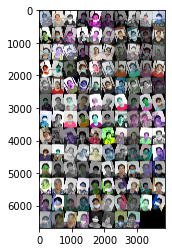

In [78]:
for data in data_loader:
    images,labels,dd = data
    plt.imshow(torchvision.utils.make_grid(images,nrow=10,normalize=True).permute(1,2,0))
    plt.show()
    break

In [79]:
def custom_imsave(img, label, file_name,n):
    load_path = '../input/data/train/augmentation/augmentation' + str(label) + '/'
    if not os.path.exists(load_path):
        os.makedirs(load_path)
    
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    image.imsave(load_path + file_name + str(n) + ".jpg", img)

In [80]:
def process(data_loader):
    for n in range(1,3):
        print(f"%d 번째 생성 중" % n)
        for batch, (images, labels, file_name) in enumerate(data_loader):
            if batch % 10 == 0:
                print("batch : " + str(batch))
            for i in range(images.size(0)):
                custom_imsave(images[i],labels[i].item(),file_name[i],n)

In [81]:
process(data_loader)

1 번째 생성 중
batch : 0
batch : 10
batch : 20
2 번째 생성 중
batch : 0
batch : 10
batch : 20


In [84]:
aug_path = glob('../input/data/train/augmentation/*/*.jpg')

In [85]:
len(aug_path)
# len(train_image_path)

22528

In [86]:
aug_train_df = pd.DataFrame(columns=["image_path","label","id"])
for img_path in aug_path:
    split_list = img_path.split("/")
    label = split_list[-2][12:]
    id = split_list[-1].split("_")[0]
    
    aug_train_df.loc[len(aug_train_df)] = [img_path,label,id]

In [471]:
# label_list = [2,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
# aug_train_df = pd.DataFrame(columns=["image_path","label","id"])

# for i in label_list:
#     for img_path in aug_path:
#         split_list = img_path.split("/")
#         label = int(split_list[-2][12:])
#         id = split_list[-1].split("_")[0]
        
#         if label == i:
#              aug_train_df.loc[len(aug_train_df)] = [img_path,label,id]

In [93]:
new_train_df = pd.concat([train_df[["image_path","label","id"]], aug_train_df])
new_train_df = new_train_df.sort_values("id")

In [94]:
new_train_df["label"] = new_train_df["label"].astype("int64")

In [96]:
new_train_df.to_csv("../input/data/train/augmentation.csv",index=False)

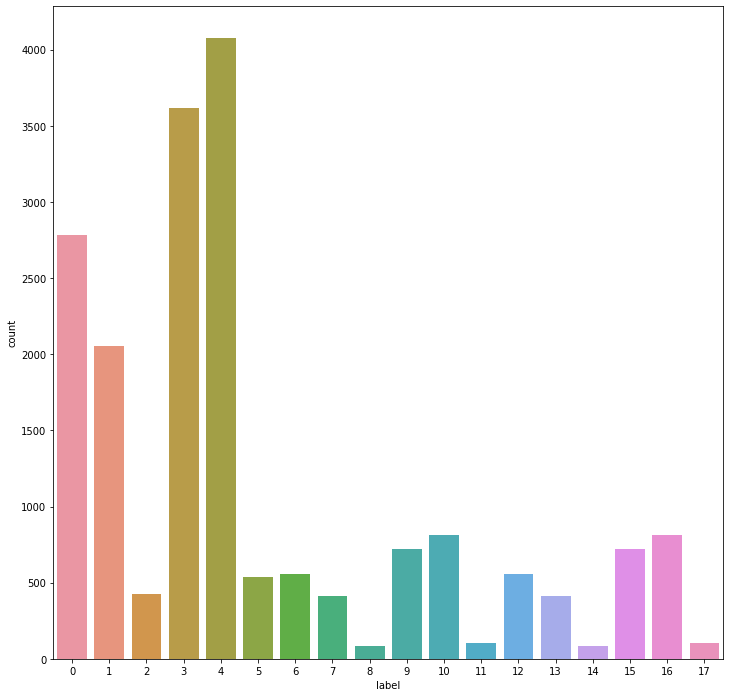

In [90]:
plt.figure(figsize = (12,12))

sns.countplot(train_df["label"])

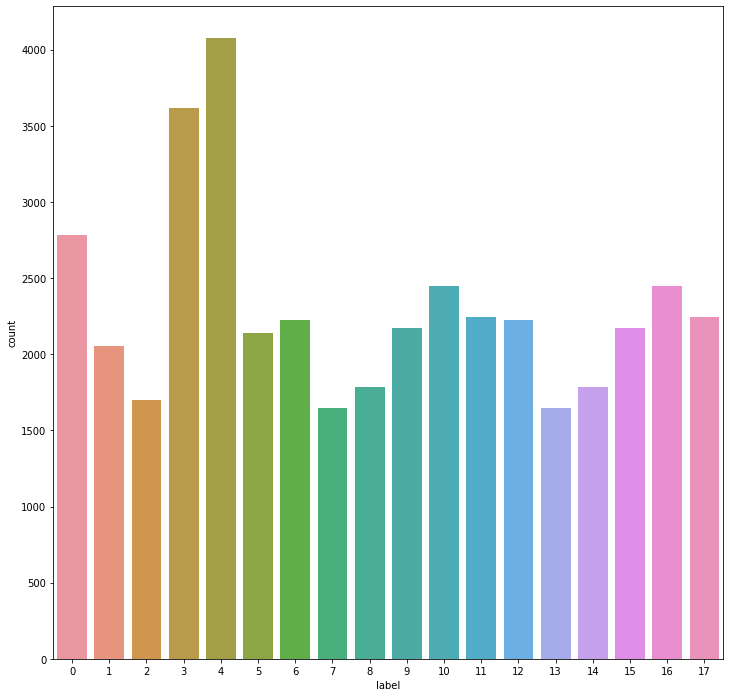

In [95]:
plt.figure(figsize = (12,12))

sns.countplot(new_train_df["label"])